# GAN in Keras
Hyungon Ryu | Sr. Solution Architect in Korea

I'm using the code from [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN) and modification to fit in Google COLAB Jupyter environment.

in the [DCGAN paper](https://arxiv.org/abs/1511.06434) describe the detail infomation about CNN style GAN, you could find original [GAN paper ](https://arxiv.org/abs/1406.2661). 

any Generative Adversarial networks composed of two deep neueral networks : 
 - **G(z)** : Generator: A deep network generates realistic images.
 - **D(x)** : Discriminator : A deep network distinguishes real images from computer generated images.

 ###  DCGAN 

 
 Mathematically, we think about dataset of examples $x1, x2, ... ,x3$ as samples from a true data distribution $p(x)$ . In the example in the below, the blue region show the part of the image space with a high probability contain real images and black dots indicate data points which means one image in the dataset. 
 
 model describes a distribution $\hat{p}(x)$ which is green in the below image that is defined implicitly by taking points from a unit of gaussian distriution which is called in noise in the code. 
 Network parameter of generative model represent the characteristic of distribution to mimic the true data distribution. Our goal is tofind parameers $\theta$ that produce a distribution that closed matches the true data distribution. in the iterative process(training) we could change and update parameters $\theta$ o strech and squeez it to better match the blue distribution. 
 ![alt text](https://blog.openai.com/content/images/2017/02/gen_models_diag_2.svg)
 
 
 In the original GAN paper, ![alt text](https://jhui.github.io/assets/gm/gan1.png)
 
  This network takes as input 100 (LSUN dataset )or 10 (MNIST dataset) random numbers drawn from a uniform distribution. We call it **latent variables**. from the latent variables, we could generated sample images **G(z)** directly using a deep network  while using a second discriminator network **D(x)** to guide the generation process. Here is the generator network: 
  
  
![DCGAN model structure](https://cdn-images-1.medium.com/max/800/1*B7y91tLgeWE-EuuFP-1XwA.png)


### DevOps for Google COLAB

before start to define model, check COLAB environment and allocate GPU. if you have problem, plz check COLAB menu **edit** and ** notebook settings** and check **GPU**

You could check 
- two 2.2Ghz CPU cores , 
- available 6GB Memory, 
- 1 K80 GPU with 11GB memory
- 300GB available  Storage


In [1]:
#check the environemnt 

print("Check H/W")
!echo "CPU " &&  lscpu | grep 'CPU(s):            '
!lscpu | grep GHz
! echo "memory" && free -m | cut -c-49 |  head -n 2 

! echo "storage" && df -h |  cut -c-60 | head -n 2
!df -h |  grep '/dev/sda1'

print("confure GPU")
! echo "GPU   " && nvidia-smi -L | cut -c-17
!nvidia-smi -ac 2505,875
!nvidia-smi -pm 1

print("\nCheck S/W")
!cat /etc/*-release | grep PRETTY_NAME
import sys
print("Python Version : ", sys.version)
print("Python result : 3+5=",3+5)
print("installed NVIDIA libraries")
!ls /usr/lib64-nvidia



Check H/W
CPU 
CPU(s):              2
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
memory
              total        used        free      
Mem:          13022         406        6718      
storage
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G  9.4G  331G   3% /
/dev/sda1       365G   14G  352G   4% /opt/bin
confure GPU
GPU   
GPU 0: Tesla K80 
Applications clocks set to "(MEM 2505, SM 875)" for GPU 00000000:00:04.0


All done.
Enabled persistence mode for GPU 00000000:00:04.0.
All done.

Check S/W
PRETTY_NAME="Ubuntu 18.04.1 LTS"
Python Version :  3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Python result : 3+5= 8
installed NVIDIA libraries
libcuda.so		       libnvidia-egl-wayland.so.1
libcuda.so.1		       libnvidia-egl-wayland.so.1.0.3
libcuda.so.396.44	       libnvidia-encode.so
libEGL_nvidia.so.0	       libnvidia-encode.so.1
libEGL_nvidia.so.396.44        libnvidia-encode.so.396.44
libEGL.so		    

Using TensorFlow backend.


for GPU memory management, I strongly recommend turn on allow_groth option in tensorflow. you could see COLAB jupyter already include :  
- tensorflow 1.11.0
- keras 2.1.6


In [2]:
'''
this is critical option. 
TF memory control allow_growth is mandatory option for COLAB
'''
import tensorflow as tf
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': 2})
config.gpu_options.allow_growth = True
session = tf.Session(config=config )
print("tensorflow version : "+tf.__version__)

import keras as K

print("keras version :", K.__version__)
!echo "GPU Memory Alloc  " && nvidia-smi  | grep MiB




tensorflow version : 1.11.0
keras version : 2.1.6
GPU Memory Alloc  
| N/A   37C    P0    57W / 149W |    117MiB / 11441MiB |      0%      Default |


# New Section

In [0]:
# configure universal 
from __future__ import print_function, division


from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

## define the networks

in the DCGAN architecture, standard CNN architecture on the discriminative model. 
```
Model for D-discriminator :
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_15 (Conv2D)           (None, 14, 14, 32)        320       
conv2d_16 (Conv2D)           (None, 7, 7, 64)          18496     
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 64)          0         
conv2d_17 (Conv2D)           (None, 4, 4, 128)         73856     
conv2d_18 (Conv2D)           (None, 4, 4, 256)         295168    
flatten_3 (Flatten)          (None, 4096)              0         
dense_5 (Dense)              (None, 1)                 4097 
```
 

![DCGAN model structure](https://cdn-images-1.medium.com/max/800/1*B7y91tLgeWE-EuuFP-1XwA.png)

```
Model for G-generator :
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_6 (Dense)              (None, 6272)              633472    
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
up_sampling2d_5 (UpSampling2 (None, 14, 14, 128)       0         
conv2d_19 (Conv2D)           (None, 14, 14, 128)       147584    
up_sampling2d_6 (UpSampling2 (None, 28, 28, 128)       0         
conv2d_20 (Conv2D)           (None, 28, 28, 64)        73792     
conv2d_21 (Conv2D)           (None, 28, 28, 1)         577            
```

In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        
        print("Model for G-generator :")

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        print("Model for D-discriminator :")
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_model()
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/images/dcgan_mnist_%d.png" % epoch)
        plt.close()
        
    def save_model(self):

        def save(model, model_name):
            model_path = "/content/saved_model/%s.json" % model_name
            weights_path = "/content/saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")
        

In [10]:
dcgan = DCGAN()

Model for D-discriminator :
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 64)   

In [0]:
display_img()

In [0]:
def reset_dir():
    import os
    model_path ='/content/saved_model'
    img_path = '/content/images'
    
    if not os.path.isdir(model_path):
        os.mkdir(model_path)
    else:
        for filename in os.listdir(model_path):
            os.remove(os.path.join(model_path,filename))

    if not os.path.isdir(img_path):
        os.mkdir(img_path)
    else:
        for filename in os.listdir(img_path):
            os.remove(os.path.join(img_path,filename))
    



In [0]:

reset_dir( )

In [58]:
%%time
dcgan.train(epochs=101, batch_size=128, save_interval=50)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.710029, acc.: 53.52%] [G loss: 0.837207]
1 [D loss: 0.677456, acc.: 56.25%] [G loss: 0.792589]
2 [D loss: 0.680024, acc.: 59.77%] [G loss: 0.789819]
3 [D loss: 0.668798, acc.: 60.55%] [G loss: 0.858926]
4 [D loss: 0.675502, acc.: 57.03%] [G loss: 0.829471]
5 [D loss: 0.709152, acc.: 52.34%] [G loss: 0.793552]
6 [D loss: 0.657267, acc.: 60.55%] [G loss: 0.776942]
7 [D loss: 0.680647, acc.: 60.94%] [G loss: 0.875650]
8 [D loss: 0.689924, acc.: 55.86%] [G loss: 0.840621]
9 [D loss: 0.661796, acc.: 60.55%] [G loss: 0.821775]
10 [D loss: 0.632040, acc.: 66.41%] [G loss: 0.859829]
11 [D loss: 0.683941, acc.: 58.20%] [G loss: 0.808017]
12 [D loss: 0.676150, acc.: 58.59%] [G loss: 0.841441]
13 [D loss: 0.682008, acc.: 57.42%] [G loss: 0.826011]
14 [D loss: 0.636790, acc.: 64.84%] [G loss: 0.863103]
15 [D loss: 0.659256, acc.: 59.77%] [G loss: 0.846530]
16 [D loss: 0.674809, acc.: 59.77%] [G loss: 0.841275]
17 [D loss: 0.691746, acc.: 55.86%] [G loss: 0.797073]
18 [D loss: 0.719801

In [0]:
def display_img():
    from IPython.display import Image, display
    import os
    flist = os.listdir("/content/images")
    flist.sort()
    for item in  flist:
        print("Epoch :",item)
        display(Image(filename="/content/images/"+item) )

Epoch : dcgan_mnist_0.png


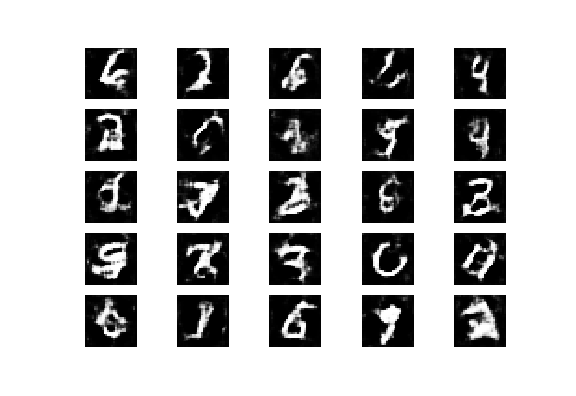

Epoch : dcgan_mnist_100.png


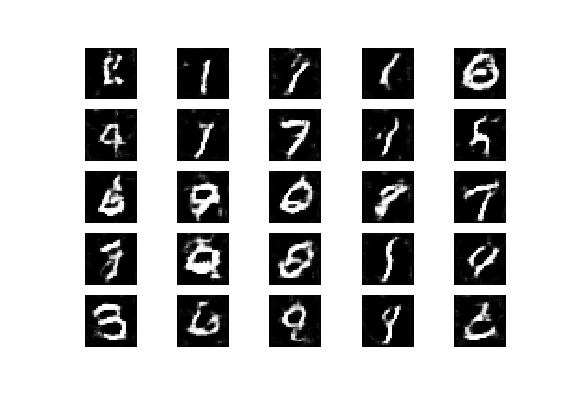

Epoch : dcgan_mnist_50.png


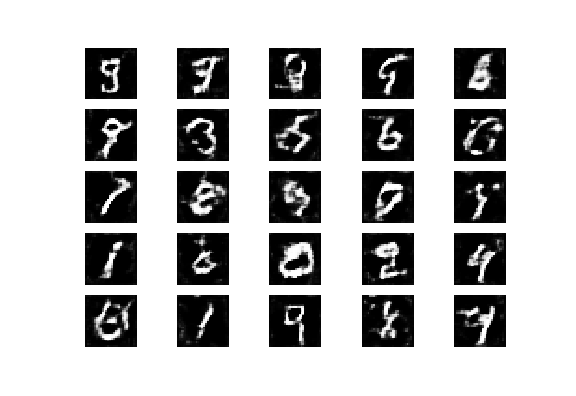

In [53]:
display_img()

In [59]:
%%time
reset_dir( )
dcgan.train(epochs=1001, batch_size=128, save_interval=100)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.667239, acc.: 57.81%] [G loss: 0.827121]
1 [D loss: 0.700334, acc.: 52.73%] [G loss: 0.826724]
2 [D loss: 0.634870, acc.: 63.28%] [G loss: 0.872570]
3 [D loss: 0.651948, acc.: 64.45%] [G loss: 0.850997]
4 [D loss: 0.657045, acc.: 60.16%] [G loss: 0.895617]
5 [D loss: 0.684399, acc.: 51.56%] [G loss: 0.835853]
6 [D loss: 0.677354, acc.: 54.69%] [G loss: 0.868818]
7 [D loss: 0.707782, acc.: 49.61%] [G loss: 0.798609]
8 [D loss: 0.666161, acc.: 56.64%] [G loss: 0.842633]
9 [D loss: 0.692561, acc.: 56.25%] [G loss: 0.766108]
10 [D loss: 0.692298, acc.: 50.78%] [G loss: 0.814066]
11 [D loss: 0.668400, acc.: 60.16%] [G loss: 0.815374]
12 [D loss: 0.670801, acc.: 56.64%] [G loss: 0.882475]
13 [D loss: 0.662872, acc.: 62.50%] [G loss: 0.844002]
14 [D loss: 0.679589, acc.: 55.08%] [G loss: 0.847945]
15 [D loss: 0.701996, acc.: 53.91%] [G loss: 0.828411]
16 [D loss: 0.677142, acc.: 59.38%] [G loss: 0.901658]
17 [D loss: 0.694207, acc.: 50.00%] [G loss: 0.914587]
18 [D loss: 0.680318

Epoch : dcgan_mnist_0.png


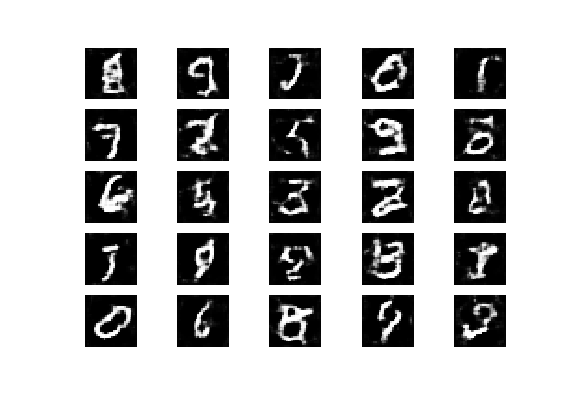

Epoch : dcgan_mnist_100.png


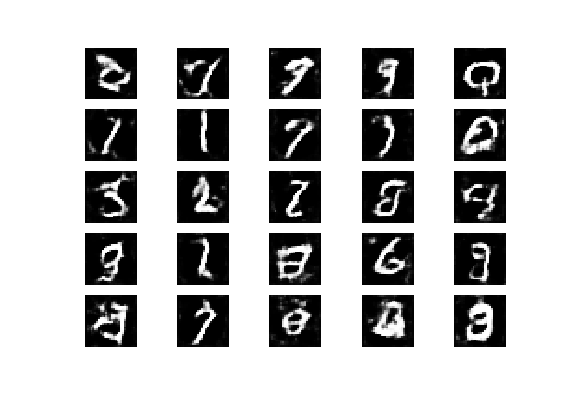

Epoch : dcgan_mnist_1000.png


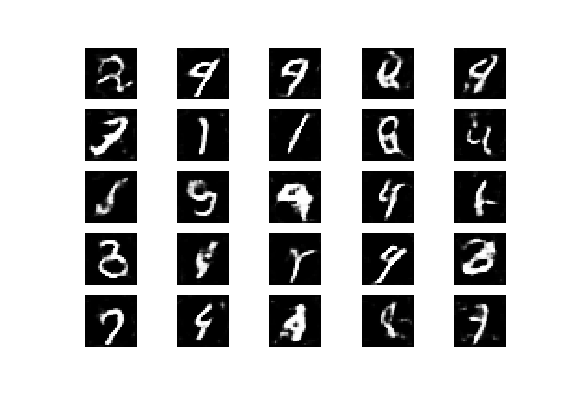

Epoch : dcgan_mnist_200.png


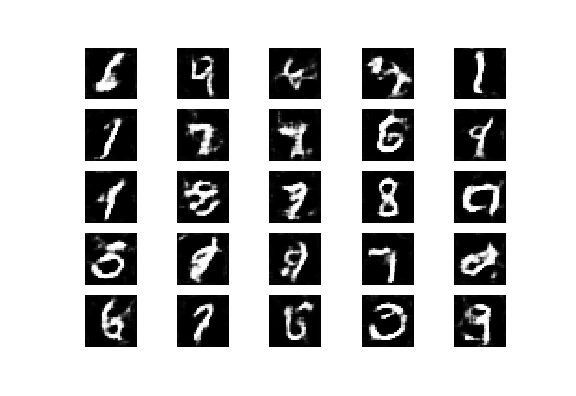

Epoch : dcgan_mnist_300.png


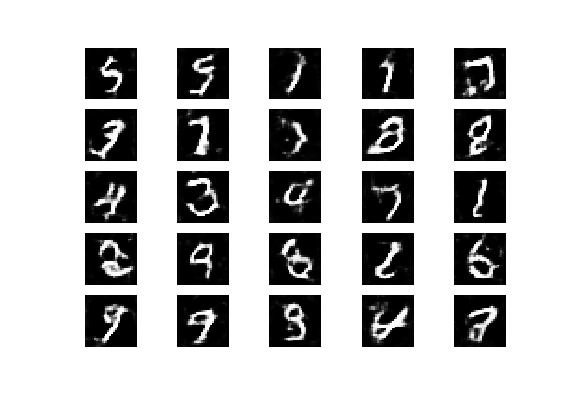

Epoch : dcgan_mnist_400.png


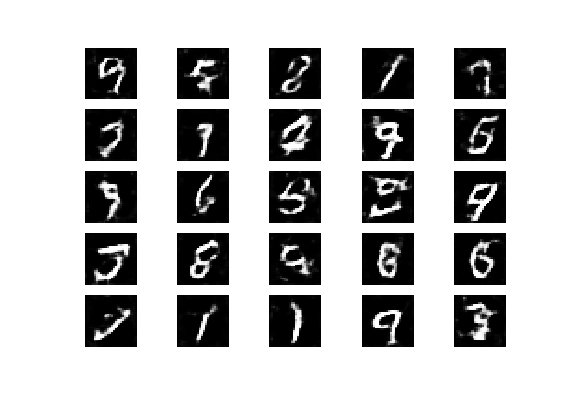

Epoch : dcgan_mnist_500.png


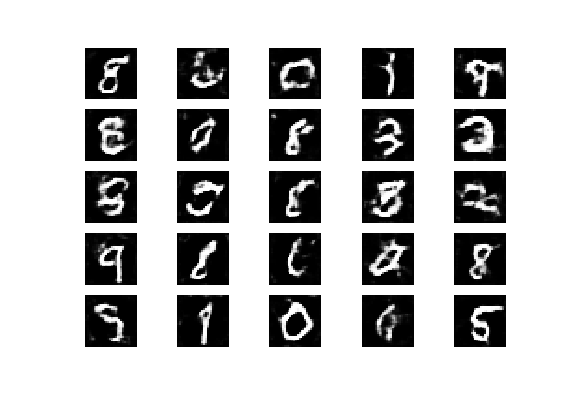

Epoch : dcgan_mnist_600.png


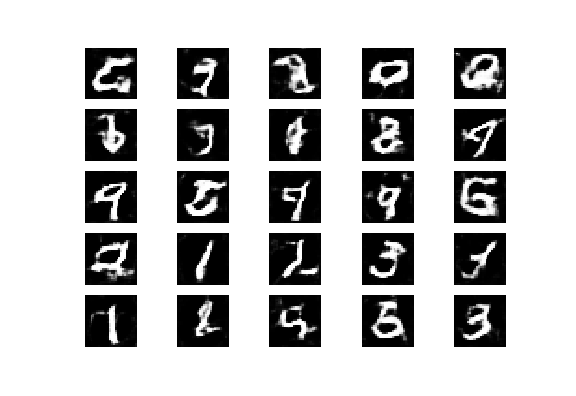

Epoch : dcgan_mnist_700.png


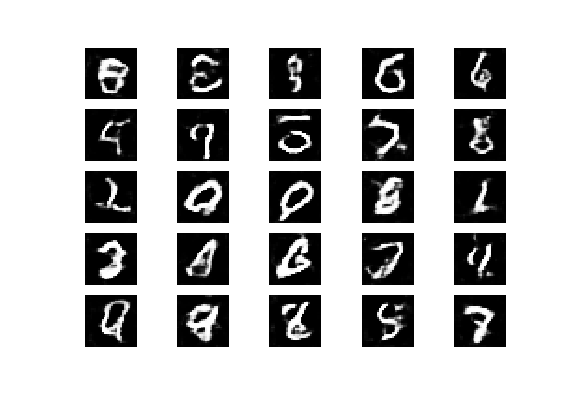

Epoch : dcgan_mnist_800.png


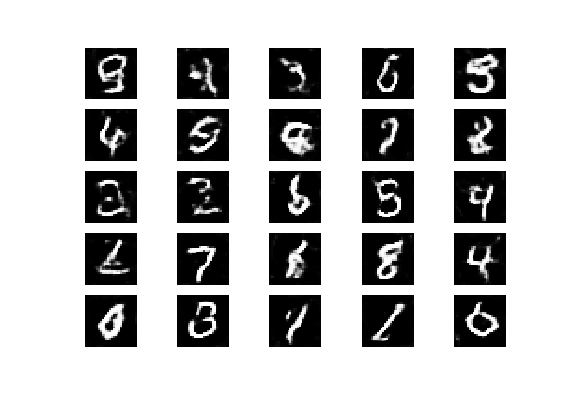

Epoch : dcgan_mnist_900.png


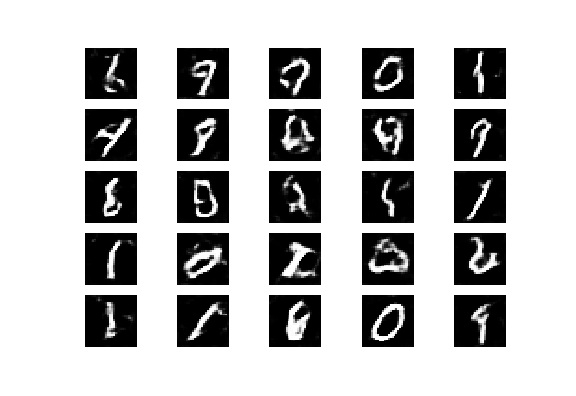

In [55]:
display_img()

In [56]:
%%time
reset_dir( )
dcgan.train(epochs=5000, batch_size=128, save_interval=1000)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.702885, acc.: 57.03%] [G loss: 0.857592]
1 [D loss: 0.683834, acc.: 57.03%] [G loss: 0.862793]
2 [D loss: 0.700816, acc.: 53.52%] [G loss: 0.888257]
3 [D loss: 0.655515, acc.: 58.20%] [G loss: 0.948678]
4 [D loss: 0.724838, acc.: 48.44%] [G loss: 0.842904]
5 [D loss: 0.708398, acc.: 54.69%] [G loss: 0.870263]
6 [D loss: 0.669298, acc.: 59.38%] [G loss: 0.921078]
7 [D loss: 0.730824, acc.: 48.44%] [G loss: 0.870926]
8 [D loss: 0.692549, acc.: 55.47%] [G loss: 0.893039]
9 [D loss: 0.716022, acc.: 46.88%] [G loss: 0.865735]
10 [D loss: 0.697554, acc.: 55.47%] [G loss: 0.815442]
11 [D loss: 0.696797, acc.: 55.47%] [G loss: 0.861195]
12 [D loss: 0.693560, acc.: 58.20%] [G loss: 0.854101]
13 [D loss: 0.692312, acc.: 56.25%] [G loss: 0.889696]
14 [D loss: 0.662219, acc.: 60.55%] [G loss: 0.925017]
15 [D loss: 0.711840, acc.: 52.34%] [G loss: 0.863986]
16 [D loss: 0.662766, acc.: 63.67%] [G loss: 0.971069]
17 [D loss: 0.732037, acc.: 50.00%] [G loss: 0.865495]
18 [D loss: 0.686298

KeyboardInterrupt: ignored

Epoch : dcgan_mnist_0.png


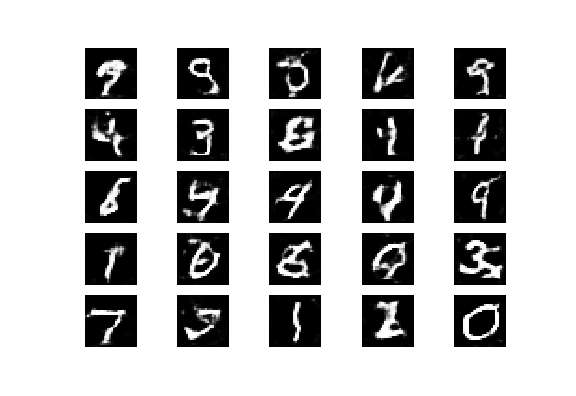

Epoch : dcgan_mnist_1000.png


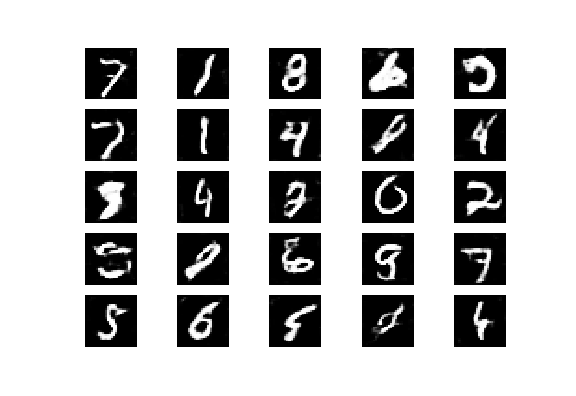

Epoch : dcgan_mnist_2000.png


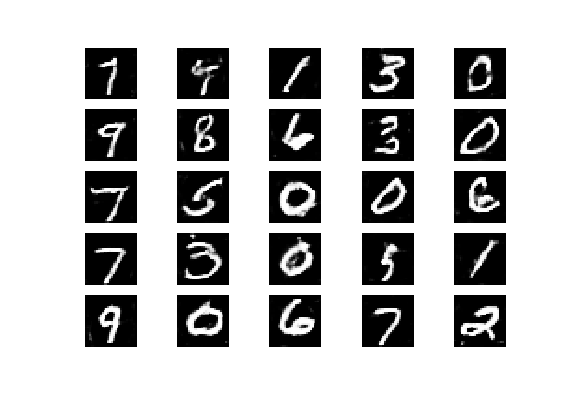

Epoch : dcgan_mnist_3000.png


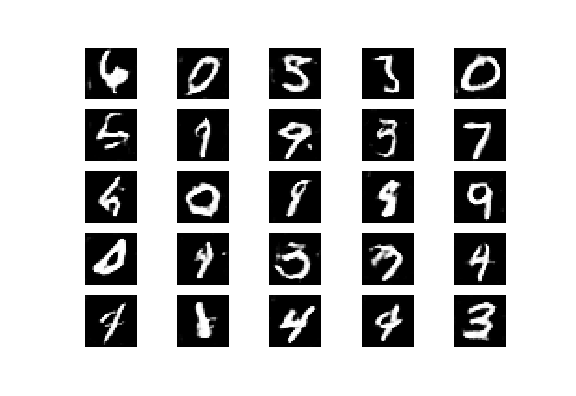

Epoch : dcgan_mnist_4000.png


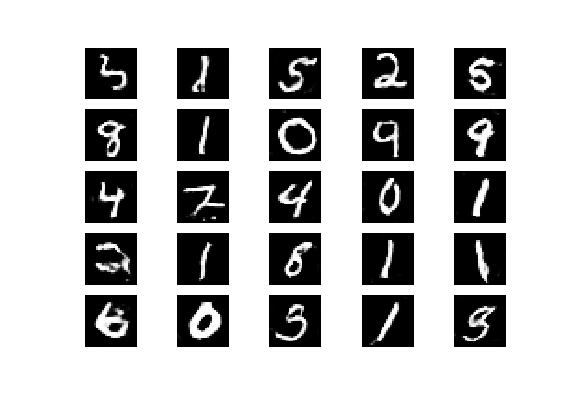

Epoch : dcgan_mnist_5000.png


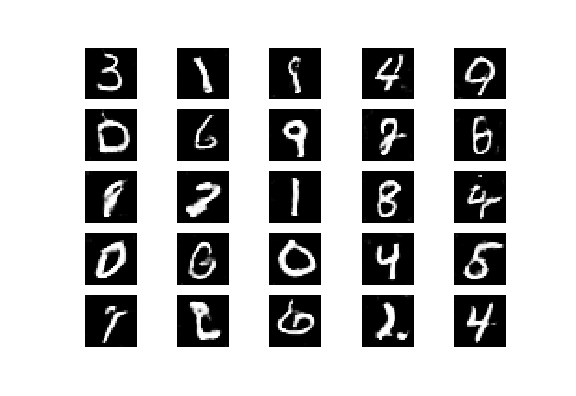

Epoch : dcgan_mnist_6000.png


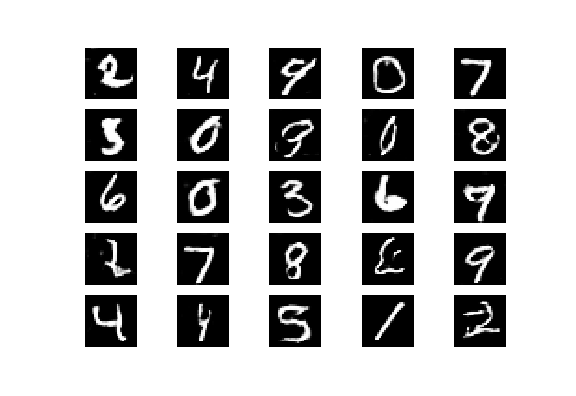

Epoch : dcgan_mnist_7000.png


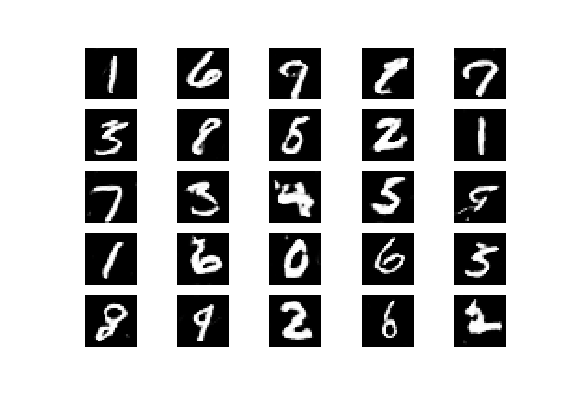

In [57]:
display_img()

In [0]:
reset_dir( )
dcgan.train(epochs=10001, batch_size=128, save_interval=1000)
display_img()

In [0]:
reset_dir( )
dcgan.train(epochs=10001, batch_size=128, save_interval=1000)
display_img()

In [0]:
reset_dir( )
dcgan.train(epochs=10001, batch_size=128, save_interval=1000)
display_img()

# W GAN

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

In [0]:
class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [65]:
reset_dir( )
wgan = WGAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 32)          0         
__________

In [67]:
%%time
wgan.train(epochs=1000, batch_size=128, sample_interval=200)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999973] [G loss: 1.000122]
1 [D loss: 0.999971] [G loss: 1.000120]
2 [D loss: 0.999973] [G loss: 1.000120]
3 [D loss: 0.999972] [G loss: 1.000122]
4 [D loss: 0.999972] [G loss: 1.000118]
5 [D loss: 0.999971] [G loss: 1.000121]
6 [D loss: 0.999971] [G loss: 1.000118]
7 [D loss: 0.999972] [G loss: 1.000118]
8 [D loss: 0.999972] [G loss: 1.000121]
9 [D loss: 0.999973] [G loss: 1.000119]
10 [D loss: 0.999974] [G loss: 1.000121]
11 [D loss: 0.999973] [G loss: 1.000120]
12 [D loss: 0.999972] [G loss: 1.000120]
13 [D loss: 0.999973] [G loss: 1.000119]
14 [D loss: 0.999971] [G loss: 1.000122]
15 [D loss: 0.999972] [G loss: 1.000118]
16 [D loss: 0.999973] [G loss: 1.000121]
17 [D loss: 0.999972] [G loss: 1.000120]
18 [D loss: 0.999973] [G loss: 1.000121]
19 [D loss: 0.999973] [G loss: 1.000121]
20 [D loss: 0.999973] [G loss: 1.000119]
21 [D loss: 0.999972] [G loss: 1.000116]
22 [D loss: 0.999974] [G loss: 1.000120]
23 [D loss: 0.999973] [G loss: 1.000119]
24 [D loss: 0.999972] [G l

Epoch : mnist_0.png


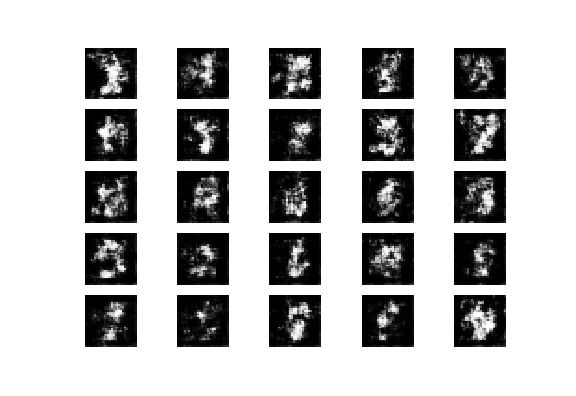

Epoch : mnist_200.png


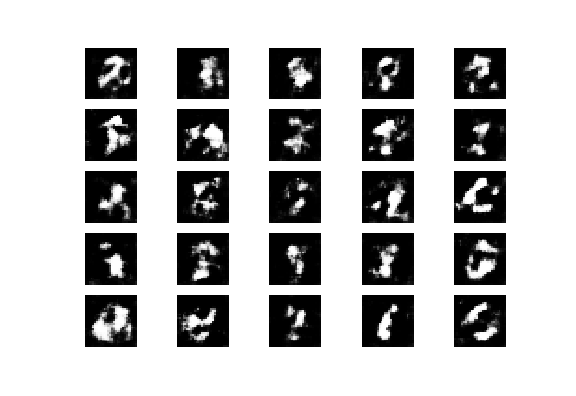

Epoch : mnist_400.png


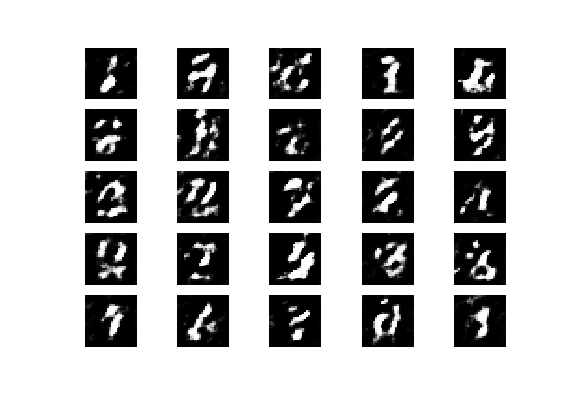

Epoch : mnist_600.png


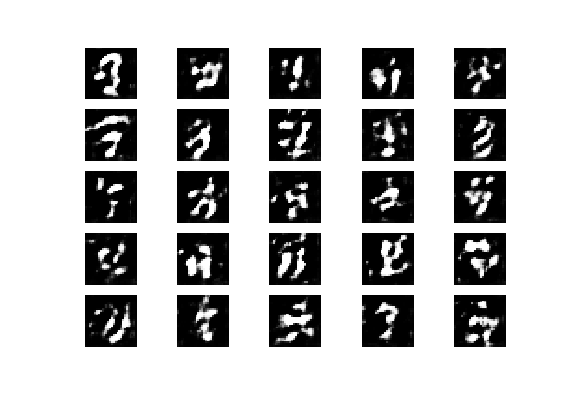

Epoch : mnist_800.png


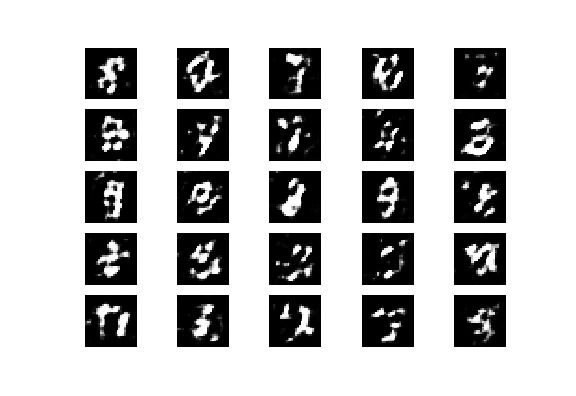

In [68]:
display_img()